In [1]:
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np
import string
import tensorflow as tf

In [2]:
train_label_length = np.load(r'C:\Aditya\Project Book\New\numpy_save\train_label_length.npy')
train_input_length = np.load(r'C:\Aditya\Project Book\New\numpy_save\train_input_length.npy')
training_img = np.load(r'C:\Aditya\Project Book\New\numpy_save\training_img.npy')
train_padded_txt = np.load(r'C:\Aditya\Project Book\New\numpy_save\train_padded_txt.npy')
max_label_len = np.load(r'C:\Aditya\Project Book\New\numpy_save\max_label_len.npy')

In [3]:
print(train_label_length.shape)
print(train_input_length.shape)
print(training_img.shape)
print(train_padded_txt.shape)

(390000,)
(390000,)
(390000, 32, 128, 1)
(390000, 22)


In [4]:
char_list = string.ascii_letters+string.digits
inputs = Input(shape=(32,128,1))
s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(s)
conv_1 = Dropout(0.25)(conv_1)
conv_1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_1)
conv_2= BatchNormalization(axis=-1)(conv_2)
conv_2 = Dropout(0.25)(conv_2)
conv_2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(conv_2)
 
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(pool_2)
conv_3= BatchNormalization(axis=-1)(conv_3)
conv_3 = Dropout(0.25)(conv_3)
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
conv_4 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1), padding='same')(conv_4)
 
conv_5 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 lambda (Lambda)             (None, 32, 128, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 dropout (Dropout)           (None, 32, 128, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 128, 32)       4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                             

In [5]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [6]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = keras.optimizers.Adam(learning_rate=0.0005), metrics=['acc'])
 
filepath= r"C:\Aditya\Project Book\New\model\best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [7]:
import matplotlib.pyplot as plt
def display(x,y):

  # load the saved best model weights
  act_model.load_weights(r'C:\Aditya\Project Book\New\model\best_model.h5')
  act_model.save(r'C:\Aditya\Project Book\New\model\act_model.h5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n')    

class DisplayCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global model
    model.save(r'C:\Aditya\Project Book\New\model\model.h5')
    i = np.random.randint(360000)
    display(training_img[i],train_padded_txt[i])

Exception reporting mode: Verbose
Epoch 1/20
350/350 [==============================] - ETA: 0s - loss: 27.9706 - acc: 0.0000e+00
Epoch 1: val_loss improved from inf to 29.83238, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 1s 775ms/step


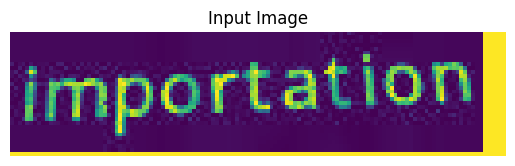

predicted text = S

350/350 [==============================] - 2598s 7s/step - loss: 27.9706 - acc: 0.0000e+00 - val_loss: 29.8324 - val_acc: 0.0000e+00
Epoch 2/20
350/350 [==============================] - ETA: 0s - loss: 24.3690 - acc: 0.0000e+00
Epoch 2: val_loss improved from 29.83238 to 22.78819, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 37ms/step


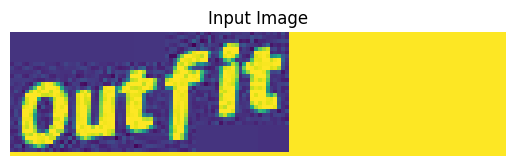

predicted text = muis

350/350 [==============================] - 2925s 8s/step - loss: 24.3690 - acc: 0.0000e+00 - val_loss: 22.7882 - val_acc: 0.0000e+00
Epoch 3/20
350/350 [==============================] - ETA: 0s - loss: 14.2246 - acc: 0.0025
Epoch 3: val_loss improved from 22.78819 to 8.83940, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 21ms/step


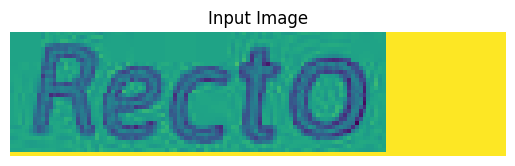

predicted text = Recto

350/350 [==============================] - 2316s 7s/step - loss: 14.2246 - acc: 0.0025 - val_loss: 8.8394 - val_acc: 0.0328
Epoch 4/20
350/350 [==============================] - ETA: 0s - loss: 6.6769 - acc: 0.1221 
Epoch 4: val_loss improved from 8.83940 to 4.59286, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 35ms/step


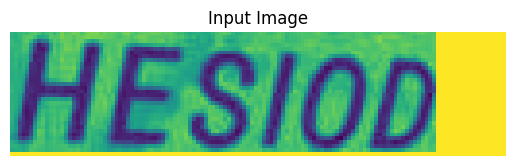

predicted text = HESIOD

350/350 [==============================] - 4743s 14s/step - loss: 6.6769 - acc: 0.1221 - val_loss: 4.5929 - val_acc: 0.3444
Epoch 5/20
350/350 [==============================] - ETA: 0s - loss: 4.9690 - acc: 0.2883 
Epoch 5: val_loss improved from 4.59286 to 3.77514, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 33ms/step


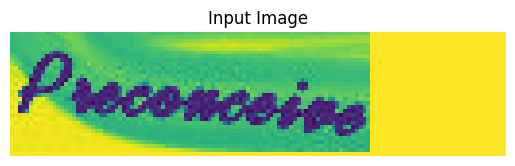

predicted text = Piscorceies

350/350 [==============================] - 5069s 14s/step - loss: 4.9690 - acc: 0.2883 - val_loss: 3.7751 - val_acc: 0.4689
Epoch 6/20
350/350 [==============================] - ETA: 0s - loss: 4.2115 - acc: 0.3835 
Epoch 6: val_loss improved from 3.77514 to 3.33692, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 33ms/step


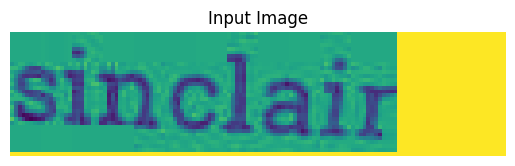

predicted text = sinclair

350/350 [==============================] - 5042s 14s/step - loss: 4.2115 - acc: 0.3835 - val_loss: 3.3369 - val_acc: 0.5462
Epoch 7/20
350/350 [==============================] - ETA: 0s - loss: 3.7486 - acc: 0.4426 
Epoch 7: val_loss improved from 3.33692 to 3.03945, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 32ms/step


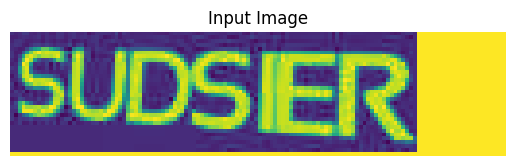

predicted text = SUDSIER

350/350 [==============================] - 5066s 14s/step - loss: 3.7486 - acc: 0.4426 - val_loss: 3.0395 - val_acc: 0.5805
Epoch 8/20
350/350 [==============================] - ETA: 0s - loss: 3.4157 - acc: 0.4851
Epoch 8: val_loss improved from 3.03945 to 2.81883, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 20ms/step


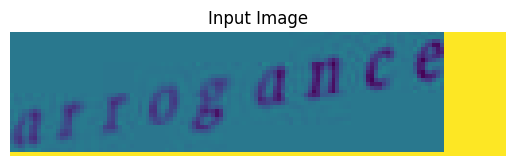

predicted text = arrogance

350/350 [==============================] - 1983s 6s/step - loss: 3.4157 - acc: 0.4851 - val_loss: 2.8188 - val_acc: 0.6027
Epoch 9/20
350/350 [==============================] - ETA: 0s - loss: 3.1713 - acc: 0.5167 
Epoch 9: val_loss improved from 2.81883 to 2.63102, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 33ms/step


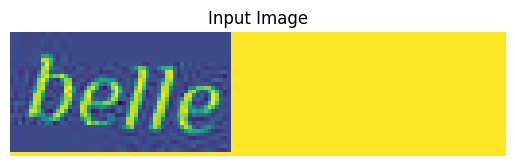

predicted text = belle

350/350 [==============================] - 4140s 12s/step - loss: 3.1713 - acc: 0.5167 - val_loss: 2.6310 - val_acc: 0.6214
Epoch 10/20
350/350 [==============================] - ETA: 0s - loss: 2.9754 - acc: 0.5424
Epoch 10: val_loss improved from 2.63102 to 2.53499, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 20ms/step


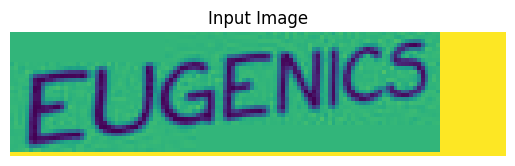

predicted text = EUGENICS

350/350 [==============================] - 2109s 6s/step - loss: 2.9754 - acc: 0.5424 - val_loss: 2.5350 - val_acc: 0.6463
Epoch 11/20
350/350 [==============================] - ETA: 0s - loss: 2.8540 - acc: 0.5582
Epoch 11: val_loss did not improve from 2.53499
1/1 [==============================] - 0s 20ms/step


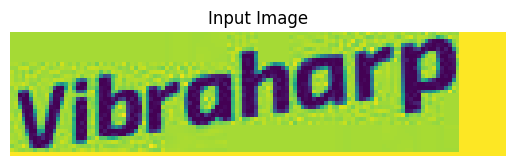

predicted text = Vibraharp

350/350 [==============================] - 1865s 5s/step - loss: 2.8540 - acc: 0.5582 - val_loss: 2.5415 - val_acc: 0.6369
Epoch 12/20
350/350 [==============================] - ETA: 0s - loss: 2.8062 - acc: 0.5630
Epoch 12: val_loss improved from 2.53499 to 2.48007, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 20ms/step


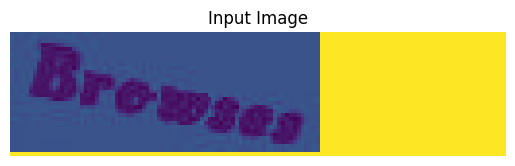

predicted text = Browses

350/350 [==============================] - 2101s 6s/step - loss: 2.8062 - acc: 0.5630 - val_loss: 2.4801 - val_acc: 0.6691
Epoch 13/20
350/350 [==============================] - ETA: 0s - loss: 2.6590 - acc: 0.5814
Epoch 13: val_loss improved from 2.48007 to 2.36622, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 21ms/step


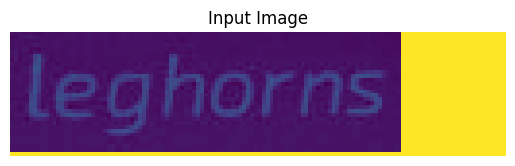

predicted text = leghorns

350/350 [==============================] - 1955s 6s/step - loss: 2.6590 - acc: 0.5814 - val_loss: 2.3662 - val_acc: 0.6680
Epoch 14/20
350/350 [==============================] - ETA: 0s - loss: 2.5473 - acc: 0.5965
Epoch 14: val_loss improved from 2.36622 to 2.27638, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 21ms/step


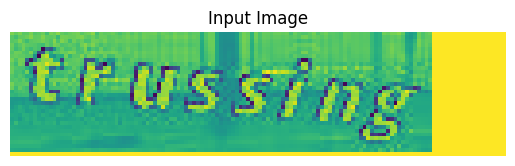

predicted text = trussing

350/350 [==============================] - 1835s 5s/step - loss: 2.5473 - acc: 0.5965 - val_loss: 2.2764 - val_acc: 0.6722
Epoch 15/20
350/350 [==============================] - ETA: 0s - loss: 2.4443 - acc: 0.6092
Epoch 15: val_loss improved from 2.27638 to 2.25850, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 22ms/step


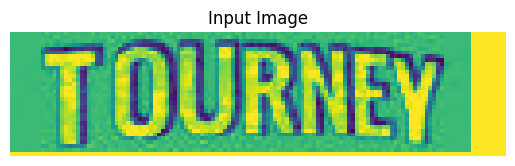

predicted text = TOURNEY

350/350 [==============================] - 1836s 5s/step - loss: 2.4443 - acc: 0.6092 - val_loss: 2.2585 - val_acc: 0.6652
Epoch 16/20
350/350 [==============================] - ETA: 0s - loss: 2.3460 - acc: 0.6211
Epoch 16: val_loss improved from 2.25850 to 2.21419, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 20ms/step


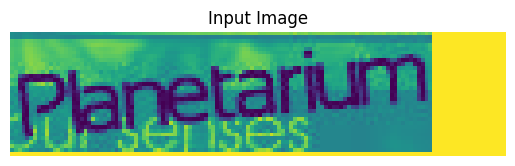

predicted text = Planetarium

350/350 [==============================] - 1852s 5s/step - loss: 2.3460 - acc: 0.6211 - val_loss: 2.2142 - val_acc: 0.6979
Epoch 17/20
350/350 [==============================] - ETA: 0s - loss: 2.2549 - acc: 0.6328
Epoch 17: val_loss improved from 2.21419 to 2.18431, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 22ms/step


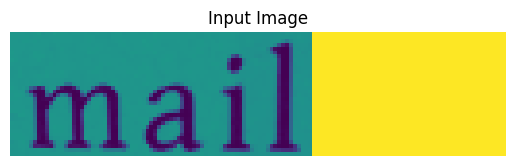

predicted text = mail

350/350 [==============================] - 2031s 6s/step - loss: 2.2549 - acc: 0.6328 - val_loss: 2.1843 - val_acc: 0.6961
Epoch 18/20
350/350 [==============================] - ETA: 0s - loss: 2.1767 - acc: 0.6425
Epoch 18: val_loss improved from 2.18431 to 2.11324, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 21ms/step


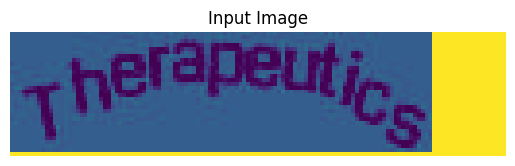

predicted text = Therapeuties

350/350 [==============================] - 1859s 5s/step - loss: 2.1767 - acc: 0.6425 - val_loss: 2.1132 - val_acc: 0.7114
Epoch 19/20
350/350 [==============================] - ETA: 0s - loss: 2.1710 - acc: 0.6458
Epoch 19: val_loss did not improve from 2.11324
1/1 [==============================] - 0s 21ms/step


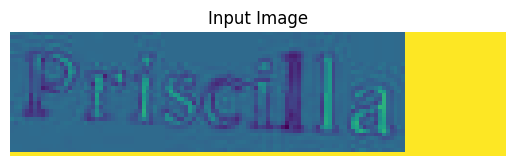

predicted text = Priscilla

350/350 [==============================] - 1884s 5s/step - loss: 2.1710 - acc: 0.6458 - val_loss: 2.2905 - val_acc: 0.6591
Epoch 20/20
350/350 [==============================] - ETA: 0s - loss: 2.1098 - acc: 0.6508
Epoch 20: val_loss improved from 2.11324 to 2.10339, saving model to C:\Aditya\Project Book\New\model\best_model.h5
1/1 [==============================] - 0s 22ms/step


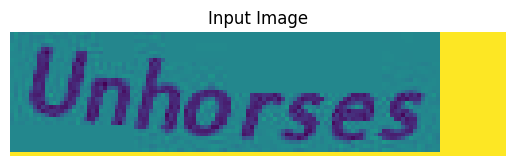

predicted text = Unhorses

350/350 [==============================] - 1816s 5s/step - loss: 2.1098 - acc: 0.6508 - val_loss: 2.1034 - val_acc: 0.7145


In [8]:
%xmode Verbose

batch_size = 1026
epochs = 20

callbacks_list = [checkpoint, DisplayCallback()]

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length]
          , y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs, 
          validation_split = 0.08,
          verbose = 1,
          callbacks = callbacks_list )

# model.save(r"C:\Aditya\Project Book\New\model\best_model.hdf5")
model.save(r"C:\Aditya\Project Book\New\model\best_model.h5")

In [ ]:
# model = tf.keras.models.load_model(r'C:\Aditya\Project Book\New\model\model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(act_model)
# tflite_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)